<a href="https://colab.research.google.com/github/dmarx/StyleGANXL-CLIP/blob/main/StyleganXL%2BCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **StyleGANXL + CLIP 🖼️**: SlightlyStable edition via DigThatData

## Generate images from text prompts using StyleGANXL with CLIP guidance.

(Modified by Katherine Crowson to optimize in W+ space)

This notebook is a work in progress, head over [here](https://github.com/CasualGANPapers/unconditional-StyleGAN-CLIP) if you want to be up to date with its changes.

Largely based on code by  [Katherine Crowson](https://github.com/crowsonkb) and [nshepperd](https://github.com/nshepperd).

Mostly made possible because of [StyleGAN-XL](https://github.com/autonomousvision/stylegan_xl) and [CLIP](https://github.com/openai/CLIP).

Created by [Eugenio Herrera](https://github.com/ouhenio) and [Rodrigo Mello](https://github.com/ryudrigo).


In [1]:
#@markdown #**Install stuff** 🏗️🛠️
# @markdown This cell will take a while.

#@markdown ---

#!git clone https://github.com/autonomousvision/stylegan_xl
!pip install einops ninja
!pip install timm
!pip install napm 

#sys.path.append('./stylegan_xl')
import napm
url = 'https://github.com/autonomousvision/stylegan_xl'
napm.pseudoinstall_git_repo(url, add_install_dir_to_path=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 47.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 32.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 613 kB/s 
     |████████████████████████████████| 58 kB 7.7 MB/s 
     |████████████████████████████████| 79 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 45.5 MB/s 
     |████████████████████████████████| 117 kB 67.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=8f909d4206c74542b6e08ad6abdeff8ae1326711151a08cfb6d5aa7ea3dc16a4
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully 

2022-07-29 18:47:19.132 | DEBUG    | napm.config:config_path:28 - /root/.cache/napm/config.yaml
2022-07-29 18:47:19.134 | DEBUG    | napm.config:config_path:31 - Creating config file at /root/.cache/napm/config.yaml
2022-07-29 18:47:19.140 | DEBUG    | napm.config:config_path:28 - /root/.cache/napm/config.yaml
2022-07-29 18:47:21.045 | DEBUG    | napm.pseudo_install:pseudoinstall_git_repo:64 - Added /root/.cache/napm/stylegan_xl to sys.path
2022-07-29 18:47:21.047 | DEBUG    | napm.config:config_path:28 - /root/.cache/napm/config.yaml
2022-07-29 18:47:21.056 | DEBUG    | napm.config:config_path:28 - /root/.cache/napm/config.yaml


In [2]:
#try:
#    import mmc
#except:
#    # install mmc
#    !git clone https://github.com/dmarx/Multi-Modal-Comparators
#    !pip install poetry
#    !cd Multi-Modal-Comparators; poetry build
#    !cd Multi-Modal-Comparators; pip install dist/mmc*.whl
#    !python Multi-Modal-Comparators/src/mmc/napm_installs/__init__.py


In [3]:
%%capture

# just use the machinery in pytti for now
# super bloated installation relative to what we need


# { display-mode: 'form' }


## 1. Install stuff

#try: 
#    import pytti
#except ImportError:
#    !pip install kornia pytorch-lightning transformers
#    !pip install jupyter loguru einops PyGLM ftfy regex tqdm hydra-core exrex
#    !pip install seaborn adjustText bunch matplotlib-label-lines
#    !pip install --upgrade gdown

#    !pip install --upgrade git+https://github.com/pytti-tools/AdaBins.git
!pip install --upgrade git+https://github.com/pytti-tools/GMA.git
#    !pip install --upgrade git+https://github.com/pytti-tools/taming-transformers.git
!pip install --upgrade git+https://github.com/openai/CLIP.git
#    !pip install --upgrade git+https://github.com/pytti-tools/pytti-core.git


In [4]:


import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip # should get installed with mmc?
import unicodedata
import re
import numpy as np

from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files

# these two are from stylegan-xl
import dnnlib
import legacy

import PIL

#from pytti.LossAug.OpticalFlowLossClass import (
#    init_GMA,
#    OpticalFlowLoss,
#)

#from pytti.Perceptor.cutouts import augs as cutouts_augs
#import mmc.loaders

In [5]:
import pkg_resources

import gma
from gma.core.network import RAFTGMA
from gma.core.utils.utils import InputPadder
from loguru import logger


GMA = None


def ir_files1(module):
    if pkg_resources.resource_exists(
        gma.__name__, "data/checkpoints/gma-sintel.pth"
    ):
        pathstr = pkg_resources.resource_filename(
            gma.__name__, "data/checkpoints/gma-sintel.pth"
        )
        logger.debug(pathstr)
        return Path(pathstr)
    else:
        raise ValueError("Unable to locate GMA checkpoint.")

logger.debug("using pkg_resources.resource_filename")


def get_gma_checkpoint_path():
    return ir_files1(gma)


def init_GMA(checkpoint_path=None, device=None):
    if checkpoint_path is None:
        checkpoint_path = get_gma_checkpoint_path()
        logger.debug(checkpoint_path)
    global GMA
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if GMA is None:
        #with vram_usage_mode("GMA"):
            # migrate this to a hydra initialize/compose operation
            parser = argparse.ArgumentParser()
            parser.add_argument(
                "--model", help="restore checkpoint", default=checkpoint_path
            )
            parser.add_argument("--model_name", help="define model name", default="GMA")
            parser.add_argument("--path", help="dataset for evaluation")
            parser.add_argument(
                "--num_heads",
                default=1,
                type=int,
                help="number of heads in attention and aggregation",
            )
            parser.add_argument(
                "--position_only",
                default=False,
                action="store_true",
                help="only use position-wise attention",
            )
            parser.add_argument(
                "--position_and_content",
                default=False,
                action="store_true",
                help="use position and content-wise attention",
            )
            parser.add_argument(
                "--mixed_precision", action="store_true", help="use mixed precision"
            )
            args = parser.parse_args([])
            GMA = torch.nn.DataParallel(RAFTGMA(args), device_ids=[device])
            # GMA = RAFTGMA(args)
            GMA.load_state_dict(torch.load(checkpoint_path))
            GMA.to(device)
            GMA.eval()



#@staticmethod
@torch.no_grad()
def get_flow(image1, image2, device=None):
    """
    Takes two images and returns the flow between them.
    :param image1: The first image in the sequence
    :param image2: the image that we want to transform towards
    :param device: The device to run the model on
    :return: the flow field.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    # init_GMA("GMA/checkpoints/gma-sintel.pth")
    #init_GMA(
    #    device=device,
    #)
    if isinstance(image1, Image.Image):
        image1 = TF.to_tensor(image1).unsqueeze(0)  # .to(device)
    if isinstance(image2, Image.Image):
        image2 = TF.to_tensor(image2).unsqueeze(0)  # .to(device)
    image1 = image1.to(device)
    image2 = image2.to(device)
    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)
    flow_low, flow_up = GMA(image1, image2, iters=12, test_mode=True)
    return flow_up


2022-07-29 18:48:02.097 | DEBUG    | __main__:<module>:24 - using pkg_resources.resource_filename


In [6]:
import argparse
from pathlib import Path

device = torch.device('cuda:0')
#print('Using device:', device, file=sys.stderr)

# Functions (many must be trimmed too)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    !wget -c '{url_or_path}'

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        #self.augs = cutouts_augs.pytti_classic()
        self.augs = lambda x: x

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return self.augs(torch.cat(cutouts))

# to do: move this. or reparameterize it. or something.
n_cutouts = 32 # @param {typvram_usage_modee:'integer'}
cut_power = 0.5 # @param {type:'number'}
make_cutouts = MakeCutouts(224, n_cutouts, cut_power)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/16"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()
init_GMA()

100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 271MiB/s]
2022-07-29 18:48:11.454 | DEBUG    | __main__:ir_files1:19 - /usr/local/lib/python3.7/dist-packages/gma/data/checkpoints/gma-sintel.pth
2022-07-29 18:48:11.460 | DEBUG    | __main__:init_GMA:34 - /usr/local/lib/python3.7/dist-packages/gma/data/checkpoints/gma-sintel.pth


In [7]:
#@markdown #**Optional:** Save outputs to Google Drive 💾
# @markdown Run this cell if you want to store the results inside Google Drive.

# @markdown Copying the generated images to drive is faster to work with.

# @markdown **Important**: you must have a folder named *samples* inside your drive, otherwise this may not work.


mount_drive = False # @param {type:'boolean'}
if mount_drive:
  from google.colab import drive
  drive.mount('/content/drive')

In [8]:
#@markdown #**Model selection** 🎭

Model = 'Imagenet-1024' #@param ["Imagenet-1024", "Imagenet-512", "Imagenet-256", "Imagenet-128", "Pokemon", "FFHQ"]

#@markdown ---

network_url = {
    "Imagenet-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl",
    "Imagenet-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl",
    "Imagenet-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl",
    "Imagenet-128": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl",
    "Pokemon-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon1024.pkl",
    "Pokemon-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon512.pkl",
    "Pokemon-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl",
    "FFHQ-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq256.pkl"
}

network_name = network_url[Model].split("/")[-1]
fetch_model(network_url[Model])

with dnnlib.util.open_url(network_name) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


zs = torch.randn([10000, G.mapping.z_dim], device=device)
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
for i in range(cs.shape[0]):
  cs[i,i//10]=1
w_stds = G.mapping(zs, cs)
w_stds = w_stds.reshape(10, 1000, G.num_ws, -1)
w_stds=w_stds.std(0).mean(0)[0]
w_all_classes_avg = G.mapping.w_avg.mean(0)

aggressive_stabilization = False  # @param {type:'boolean'}

dejiggle_weight=1000 # @param {type:'number'}

ema_decay = 0.5 # @param {type:'number'}

if aggressive_stabilization:
  dejiggle_weight = 0

#####################################################
# stabilization snippet via @PDillis
# https://twitter.com/PDillis/status/1551673599878209544
if hasattr(G.synthesis, 'input') and aggressive_stabilization:
    if G.c_dim == 0:
        shift = (G
            .synthesis
            .input
            .affine(G.mapping.w_avg.unsqueeze(0))
            .squeeze(0)
        )
    else:
        shift = (G
            .synthesis
            .input
            .affine(G.mapping.w_avg)
            .mean(0)
        )
    G.synthesis.input.affine.bias.data.add_(shift)
    G.synthesis.input.affine.weight.data.zero_()
#####################################################

--2022-07-29 18:48:11--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.59
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1965027957 (1.8G) [binary/octet-stream]
Saving to: ‘imagenet1024.pkl’

imagenet1024.pkl    100%[===================>]   1.83G  14.4MB/s    in 2m 15s  

2022-07-29 18:50:28 (13.8 MB/s) - ‘imagenet1024.pkl’ saved [1965027957/1965027957]

Setting up PyTorch plugin "bias_act_plugin"... Done.


Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


  0%|          | 0/1200 [00:00<?, ?it/s]

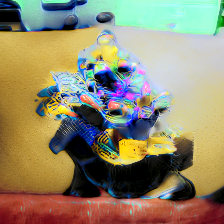

Image 0/60, steps 0/1200 | Current loss: 3.480666399002075


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


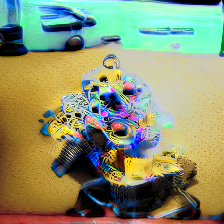

Image 1/60, steps 20/1200 | Current loss: 132200.53125


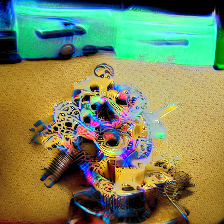

Image 2/60, steps 40/1200 | Current loss: -17255.046875


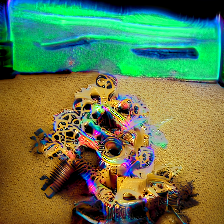

Image 3/60, steps 60/1200 | Current loss: 58323.43359375


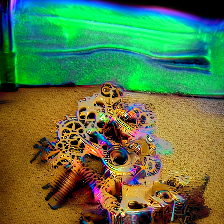

Image 4/60, steps 80/1200 | Current loss: 74899.3828125


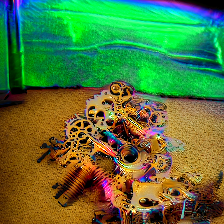

Image 5/60, steps 100/1200 | Current loss: 33596.4140625


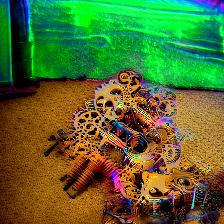

Image 6/60, steps 120/1200 | Current loss: -12432.53125


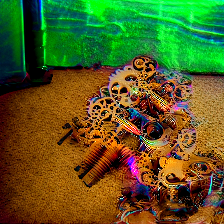

Image 7/60, steps 140/1200 | Current loss: 2516.1865234375


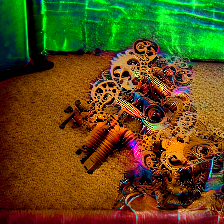

Image 8/60, steps 160/1200 | Current loss: -76022.25


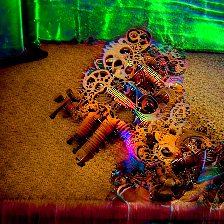

Image 9/60, steps 180/1200 | Current loss: -100844.2890625


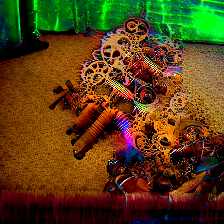

Image 10/60, steps 200/1200 | Current loss: -19958.22265625


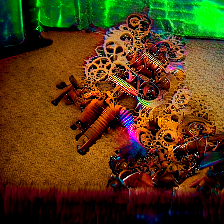

Image 11/60, steps 220/1200 | Current loss: -169.45062255859375


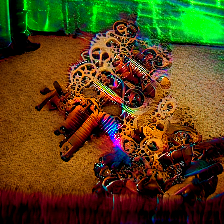

Image 12/60, steps 240/1200 | Current loss: -48926.17578125


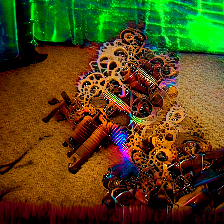

Image 13/60, steps 260/1200 | Current loss: 87258.3359375


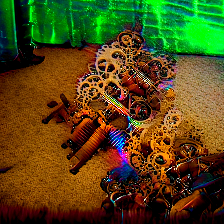

Image 14/60, steps 280/1200 | Current loss: -14723.791015625


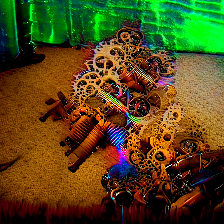

Image 15/60, steps 300/1200 | Current loss: 16816.365234375


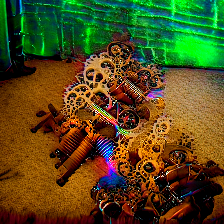

Image 16/60, steps 320/1200 | Current loss: -5469.86083984375


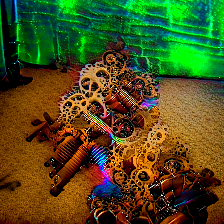

Image 17/60, steps 340/1200 | Current loss: 24486.501953125


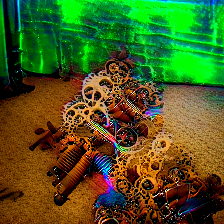

Image 18/60, steps 360/1200 | Current loss: 59299.28125


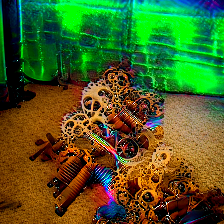

Image 19/60, steps 380/1200 | Current loss: 35662.328125


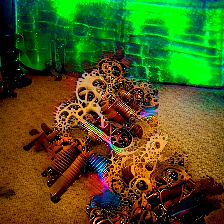

Image 20/60, steps 400/1200 | Current loss: -66168.984375


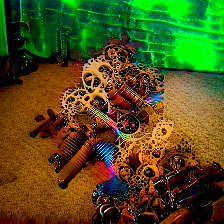

Image 21/60, steps 420/1200 | Current loss: -25805.634765625


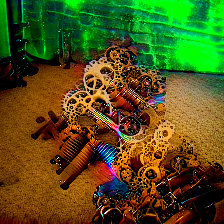

Image 22/60, steps 440/1200 | Current loss: 35340.4921875


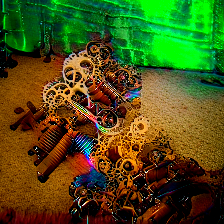

Image 23/60, steps 460/1200 | Current loss: -130798.0390625


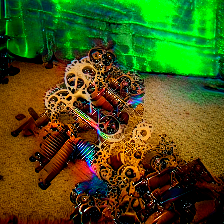

Image 24/60, steps 480/1200 | Current loss: 34861.7734375


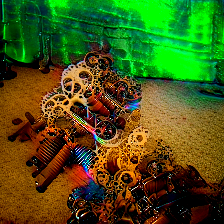

Image 25/60, steps 500/1200 | Current loss: -9010.349609375


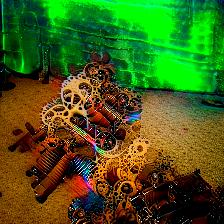

Image 26/60, steps 520/1200 | Current loss: 54389.86328125


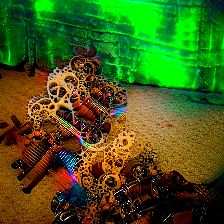

Image 27/60, steps 540/1200 | Current loss: -123344.6171875


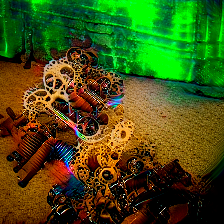

Image 28/60, steps 560/1200 | Current loss: -58996.95703125


In [ ]:
#@markdown #**Run the model** 🚀
#@markdown `texts`: Enter here a prompt to guide the image generation. You can enter more than one prompt separated with
#@markdown `|`, which will cause the guidance to focus on the different prompts at the same time, allowing to mix and play
#@markdown with the generation process.

#@markdown `steps`: Number of optimization steps. The more steps, the longer it will try to generate an image relevant to the prompt.

#@markdown `seed`: Determines the randomness seed. Using the same seed and prompt should give you similar results at every run.
#@markdown Use `-1` for a random seed.

#@markdown ---

import einops as ei


#texts = "the loom of the gods" #@param {type:"string"}
texts = "steampunk laser dance party | mechanical gears | chaotic clockwork mechanisms | colorful interference " #@param {type:"string"}
steps_per_frame =  20#@param {type:"number"}

frames_to_generate =  60#@param {type:"number"}
steps = frames_to_generate * steps_per_frame
warmup_steps = 50
seed = 12345 #@param {type:"number"}
learning_rate = 0.01 #@param {type:"number"}
reset_lr_each_frame = True # @param {type:"boolean"}

save_every = steps_per_frame

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]


tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
])

initial_batch=4 #actually that will be multiplied by initial_image_steps
initial_image_steps=warmup_steps
'''
c = torch.zeros((1000)) #just to pick a closer initial image
c[initial_class]=1
c = c.repeat(initial_batch, 1)
c=c.to(device)
'''
def run(timestring):
  flow=None
  torch.manual_seed(seed)
  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(initial_image_steps):
      a = torch.randn([initial_batch, 512], device=device)*0.6 + w_all_classes_avg*0.4
      q = ((a-w_all_classes_avg)/w_stds)
      images = G.synthesis((q * w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]))
      embeds = embed_image(images.add(1).div(2))
      loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).repeat([G.num_ws, 1]).requires_grad_()
    # print(q)
    # q = qs[i].unsqueeze(0).repeat([G.num_ws, 1])
    # q = torch.tensor(q, requires_grad=True)
    # print(q)

  im_prev=None
  # Sampling loop
  q_ema = q
  # print(q.shape)
  # opt = ESGD([q], lr=0.03, betas=(0.9, 0.999), nu=0.9)
  opt = torch.optim.AdamW([q], lr=learning_rate, betas=(0., 0.999), weight_decay=0.025)
  loop = tqdm(range(steps))
  j = 0
  for i in loop:
    opt.zero_grad()

    w = q * w_stds
    image = G.synthesis((q * w_stds + w_all_classes_avg)[None], noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()

    ##############
    # de-jiggle loss
    if (im_prev is not None) and (dejiggle_weight != 0):
        #flow = OpticalFlowLoss.get_flow(im_prev, image)
        flow = get_flow(im_prev, image)
        net_flow = flow.mean()
        loss += dejiggle_weight * net_flow

    ##############
    # loss.backward(create_graph=opt.should_create_graph())
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    if i % save_every == 0:
      q_ema = q_ema * (1-ema_decay) + q * ema_decay
      image = G.synthesis((q_ema * w_stds + w_all_classes_avg)[None],
                          noise_mode='const',                        
                          )
      if reset_lr_each_frame:
          opt = torch.optim.AdamW([q], lr=learning_rate, betas=(0., 0.999), weight_decay=0.025)

      with torch.no_grad():
        im_prev = image.clone().detach()
      if i % 10 == 0 or i == (steps - 1):
        display(TF.to_pil_image(tf(image)[0]))
        print(f"Image {j}/{frames_to_generate}, steps {i}/{steps} | Current loss: {loss}")
        #####################
        #if flow is not None:
        #  im_t_flow_fwd = ei.rearrange(flow, 'b c h w -> b h w c')
        #  arr_flow_fwd = flow_to_image(im_t_flow_fwd.squeeze().detach().clone().cpu().numpy())
        #  display(flow2pil(arr_flow_fwd))

      pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
      os.makedirs(f'samples/{timestring}', exist_ok=True)
      pil_image.save(f'samples/{timestring}/{j:04}.jpg')
      j+=1

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass

In [ ]:
#@markdown #**Generate video** 🎥

#@markdown You can edit frame rate and stuff by double-clicking this tab.

frames = os.listdir(f"samples/{timestring}")
frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

init_frame = 1 #This is the frame where the video will start
last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

#Desired video time in seconds
video_length =  5#@param {type:"number"}
#Video filename
video_name = "caffeinated_saveevery10_lr0.01_lr-reset_antijitter1000" #@param {type:"string"}
video_name = slugify(video_name)

if not video_name:
  video_name = "video"
# frames = []
# tqdm.write('Generating video...')
# for i in range(init_frame,last_frame): #
#     filename = f"samples/{timestring}/{i:04}.jpg"
#     frames.append(Image.open(filename))

fps = np.clip(total_frames/video_length,min_fps,max_fps)

print("Generating video...")
!ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# from subprocess import Popen, PIPE
# p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# for im in tqdm(frames):
#     im.save(p.stdin, 'PNG')
# p.stdin.close()

print("The video is ready")

In [ ]:
#@markdown #**Download video** 📀
#@markdown If you're activated the download to GDrive option, the video will be save there. Don't worry about overwritting issues for colliding filenames, an id will be added to them to avoid this.

#Video filename
#to_download_video_name = "caffeinated_saveevery10_lr0.01_lr-reset" #@param {type:"string"}
#to_download_video_name = slugify(to_download_video_name)

#if not to_download_video_name:
to_download_video_name = video_name


from google.colab import files
if os.path.isdir('drive/MyDrive/samples'):
  filelist = glob.glob(f'drive/MyDrive/samples/{to_download_video_name}*.mp4')
  video_count = len(filelist)
  if video_count:
    final_video_name = f"{to_download_video_name}{video_count}"
  else:
    final_video_name = to_download_video_name
  shutil.copyfile(f'samples/{video_name}.mp4', f'drive/MyDrive/samples/{final_video_name}.mp4')
else:
  files.download(f"samples/{to_download_video_name}.mp4")